<a href="https://colab.research.google.com/github/MasterNathan01/4106/blob/main/watersnathan_801283595_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN | Seq 10 | Epoch 10 | Loss: 0.4247
RNN | Seq 10 | Epoch 20 | Loss: 0.0415
RNN | Seq 10 | Epoch 30 | Loss: 0.0134
RNN | Seq 10 | Epoch 40 | Loss: 0.0079
RNN | Seq 10 | Epoch 50 | Loss: 0.0060
RNN | Seq 10 | Epoch 60 | Loss: 0.0048
RNN | Seq 10 | Epoch 70 | Loss: 0.0040
RNN | Seq 10 | Epoch 80 | Loss: 0.0033
RNN | Seq 10 | Epoch 90 | Loss: 0.0028
RNN | Seq 10 | Epoch 100 | Loss: 0.0025
RNN | Seq Length 10 | Execution Time: 0.48s | Final Loss: 0.0025
RNN | Seq 20 | Epoch 10 | Loss: 0.4094
RNN | Seq 20 | Epoch 20 | Loss: 0.0443
RNN | Seq 20 | Epoch 30 | Loss: 0.0144
RNN | Seq 20 | Epoch 40 | Loss: 0.0082
RNN | Seq 20 | Epoch 50 | Loss: 0.0062
RNN | Seq 20 | Epoch 60 | Loss: 0.0050
RNN | Seq 20 | Epoch 70 | Loss: 0.0040
RNN | Seq 20 | Epoch 80 | Loss: 0.0034
RNN | Seq 20 | Epoch 90 | Loss: 0.0029
RNN | Seq 20 | Epoch 100 | Loss: 0.0025
RNN | Seq Length 20 | Execution Time: 0.49s | Final Loss: 0.0025
RNN | Seq 30 | Epoch 10 | Loss: 0.4582
RNN | Seq 30 | Epoch 20 | Loss: 0.0610
RNN | Seq 

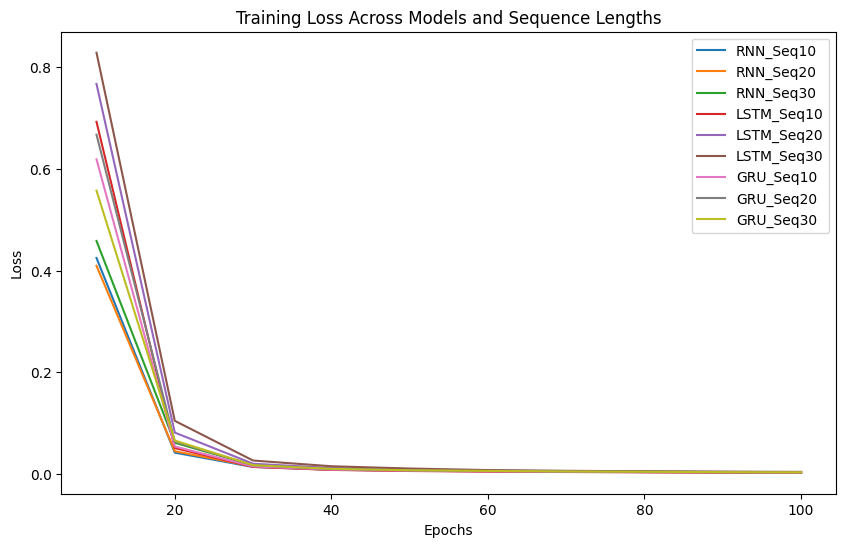

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#text data
text = """Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves..."""
chars = sorted(list(set(text)))
vocab_size = len(chars)
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

#text to numerical
encoded_text = np.array([char_to_idx[ch] for ch in text], dtype=np.int64)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return torch.tensor(np.array(X), dtype=torch.long), torch.tensor(np.array(y), dtype=torch.long)

#dataset class
class CharDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#RNN
class CharRNN(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, output_size, num_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.model_type = model_type
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'RNN':
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        output = self.fc(output[:, -1, :])
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model_type == 'LSTM':
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

#training function
def train_model(model_type, seq_length, hidden_size=128, num_layers=1, epochs=100, batch_size=64, lr=0.005):
    X, y = create_sequences(encoded_text, seq_length)
    dataset = CharDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = CharRNN(model_type, vocab_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    start_time = time.time()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            hidden = model.init_hidden(batch_x.size(0))

            optimizer.zero_grad()
            output, hidden = model(batch_x, hidden)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f'{model_type} | Seq {seq_length} | Epoch {epoch+1} | Loss: {avg_loss:.4f}')

    execution_time = time.time() - start_time

    return execution_time, avg_loss, losses

results = []
all_losses = {}
for model_type in ['RNN', 'LSTM', 'GRU']:
    for seq_length in [10, 20, 30]:
        exec_time, final_loss, losses = train_model(model_type, seq_length)
        results.append((model_type, seq_length, exec_time, final_loss))
        all_losses[f'{model_type}_Seq{seq_length}'] = losses
        print(f'{model_type} | Seq Length {seq_length} | Execution Time: {exec_time:.2f}s | Final Loss: {final_loss:.4f}')

plt.figure(figsize=(10, 6))
for key, loss_values in all_losses.items():
    epochs_reported = list(range(10, 101, 10))
    plt.plot(epochs_reported, loss_values[9::10], label=key)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Across Models and Sequence Lengths')
plt.legend()
plt.show()


Saving shakespeareloader.py to shakespeareloader (3).py
LSTM | Seq 20 | Epoch 10 | Train Loss: 1.3114 | Test Loss: 1.3715 | Accuracy: 57.82%
LSTM | Seq 20 | Epoch 20 | Train Loss: 1.2766 | Test Loss: 1.3617 | Accuracy: 58.20%
LSTM | Seq 20 | Epoch 30 | Train Loss: 1.2605 | Test Loss: 1.3633 | Accuracy: 58.24%
LSTM | Seq 20 | Epoch 40 | Train Loss: 1.2488 | Test Loss: 1.3616 | Accuracy: 58.27%
LSTM | Seq 20 | Epoch 50 | Train Loss: 1.2466 | Test Loss: 1.3603 | Accuracy: 58.38%


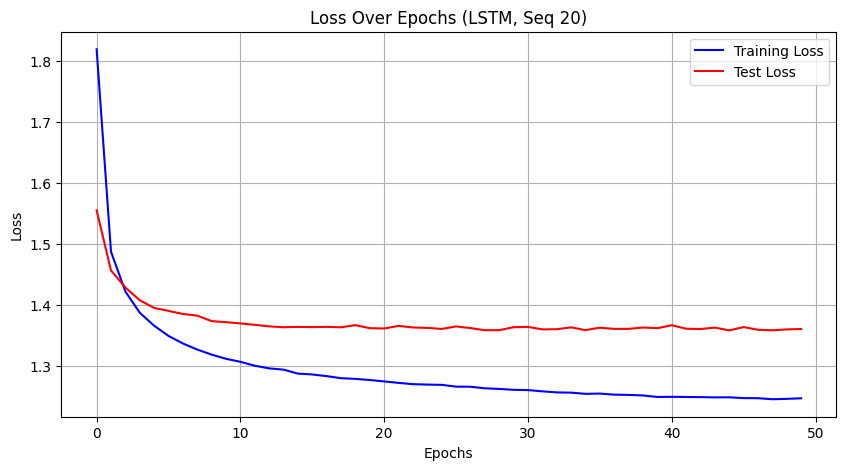


Generating text for LSTM | Seq Length 20:
ROMEO:
Ay, but shut?

KING RICHARD III:
His happy joy:
were I away, and hear some reproved:
No circumstance, and as they should,
When they wast it not to be.

LUCIO:
God that be the field me.

CORIOLANUS:
W

--------------------------------------------------------------------------------

LSTM | Seq 30 | Epoch 10 | Train Loss: 1.3243 | Test Loss: 1.3806 | Accuracy: 57.51%
LSTM | Seq 30 | Epoch 20 | Train Loss: 1.2890 | Test Loss: 1.3708 | Accuracy: 57.89%
LSTM | Seq 30 | Epoch 30 | Train Loss: 1.2770 | Test Loss: 1.3707 | Accuracy: 58.02%
LSTM | Seq 30 | Epoch 40 | Train Loss: 1.2732 | Test Loss: 1.3762 | Accuracy: 57.94%
LSTM | Seq 30 | Epoch 50 | Train Loss: 1.2682 | Test Loss: 1.3718 | Accuracy: 58.01%


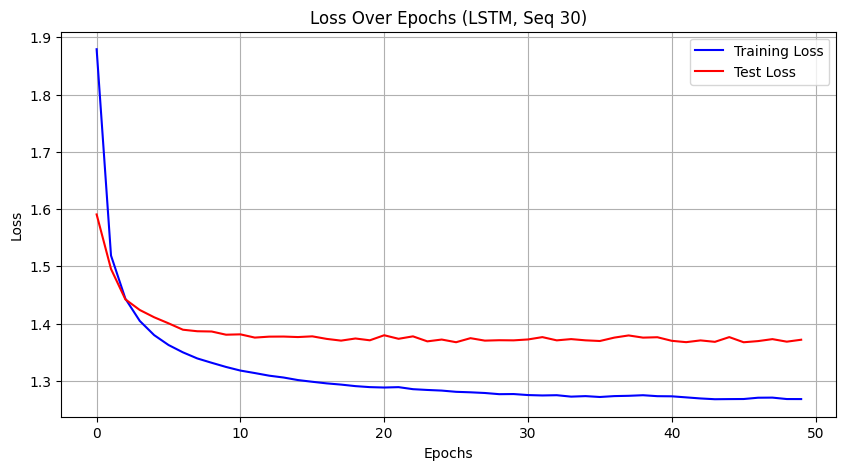


Generating text for LSTM | Seq Length 30:
ROMEO:

DUKE VINCENTIO:
It bester this injustes,
And worsted the business
Unless they have a masters of the world in banished windly
Of honour, and winded to the governments.

CATESBY:
Sluttle for our behal

--------------------------------------------------------------------------------

LSTM | Seq 50 | Epoch 10 | Train Loss: 1.3250 | Test Loss: 1.3837 | Accuracy: 57.51%
LSTM | Seq 50 | Epoch 20 | Train Loss: 1.2900 | Test Loss: 1.3720 | Accuracy: 57.94%
LSTM | Seq 50 | Epoch 30 | Train Loss: 1.2770 | Test Loss: 1.3703 | Accuracy: 58.02%
LSTM | Seq 50 | Epoch 40 | Train Loss: 1.2726 | Test Loss: 1.3704 | Accuracy: 58.11%
LSTM | Seq 50 | Epoch 50 | Train Loss: 1.2670 | Test Loss: 1.3676 | Accuracy: 58.21%


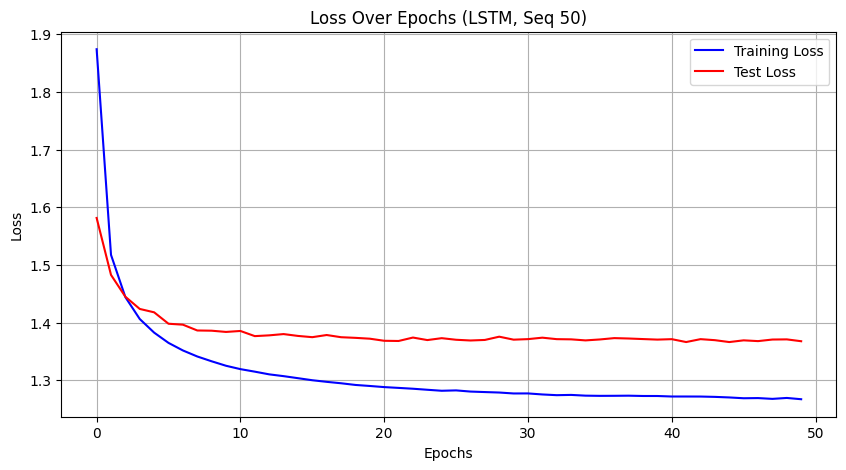


Generating text for LSTM | Seq Length 50:
ROMEO:'
What's there.

QUEEN MARGARET:
I talk of my villain, my lords,
Muster on when he had have I see for my own time of the main face,
The brains bear me; he hangs the minded champions,
Did will have no 

--------------------------------------------------------------------------------

GRU | Seq 20 | Epoch 10 | Train Loss: 1.5055 | Test Loss: 1.5326 | Accuracy: 53.66%
GRU | Seq 20 | Epoch 20 | Train Loss: 1.9373 | Test Loss: 1.9180 | Accuracy: 43.12%
GRU | Seq 20 | Epoch 30 | Train Loss: 1.7775 | Test Loss: 1.7691 | Accuracy: 47.33%
GRU | Seq 20 | Epoch 40 | Train Loss: 2.0620 | Test Loss: 2.0697 | Accuracy: 39.84%
GRU | Seq 20 | Epoch 50 | Train Loss: 2.6367 | Test Loss: 2.6581 | Accuracy: 26.50%


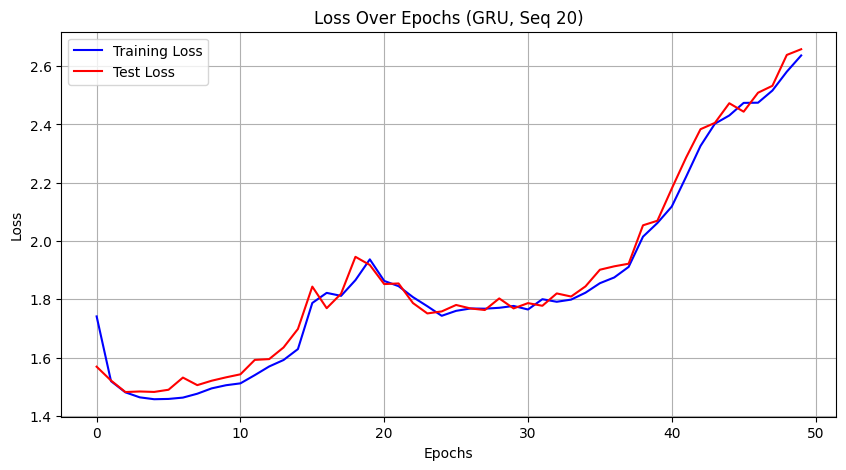


Generating text for GRU | Seq Length 20:
ROMEO:
Whreure bee, the wid he mb add so b Laripe
misk ter.

LUrsugID
Ond Mour
tared,
weow tHe her?ati'lnven,
Ph ening at ando.
An

WfIn:  It'oun dt, dae  my, bate met,
Ay h!t hther:r be moreg lortd at in c

--------------------------------------------------------------------------------

GRU | Seq 30 | Epoch 10 | Train Loss: 1.5161 | Test Loss: 1.5348 | Accuracy: 53.62%
GRU | Seq 30 | Epoch 20 | Train Loss: 2.4968 | Test Loss: 2.5702 | Accuracy: 28.92%
GRU | Seq 30 | Epoch 30 | Train Loss: 1.9720 | Test Loss: 1.9325 | Accuracy: 43.30%
GRU | Seq 30 | Epoch 40 | Train Loss: 1.7284 | Test Loss: 1.7253 | Accuracy: 48.71%
GRU | Seq 30 | Epoch 50 | Train Loss: 1.6859 | Test Loss: 1.6953 | Accuracy: 49.46%


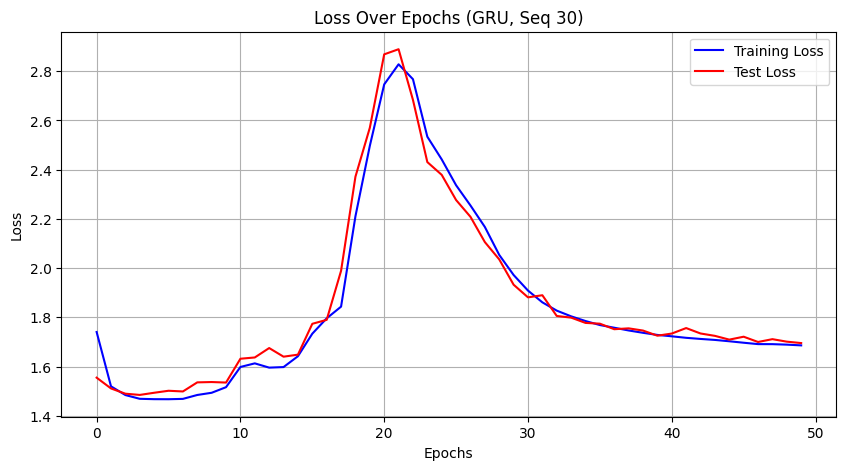


Generating text for GRU | Seq Length 30:
ROMEO:
I'll gound?


ANGELO:
We all your to a such and in wordy, who's convey in and honent, pray me with me caness, you. of what prevered of here
And sad on our hear a parroks nect away.

MARCIUS:
Serve to

--------------------------------------------------------------------------------

GRU | Seq 50 | Epoch 10 | Train Loss: 1.5496 | Test Loss: 1.6015 | Accuracy: 51.97%
GRU | Seq 50 | Epoch 20 | Train Loss: 2.2949 | Test Loss: 2.3740 | Accuracy: 32.91%
GRU | Seq 50 | Epoch 30 | Train Loss: 2.4573 | Test Loss: 2.4765 | Accuracy: 30.06%
GRU | Seq 50 | Epoch 40 | Train Loss: 2.3141 | Test Loss: 2.3582 | Accuracy: 31.26%
GRU | Seq 50 | Epoch 50 | Train Loss: 2.1109 | Test Loss: 2.0882 | Accuracy: 38.79%


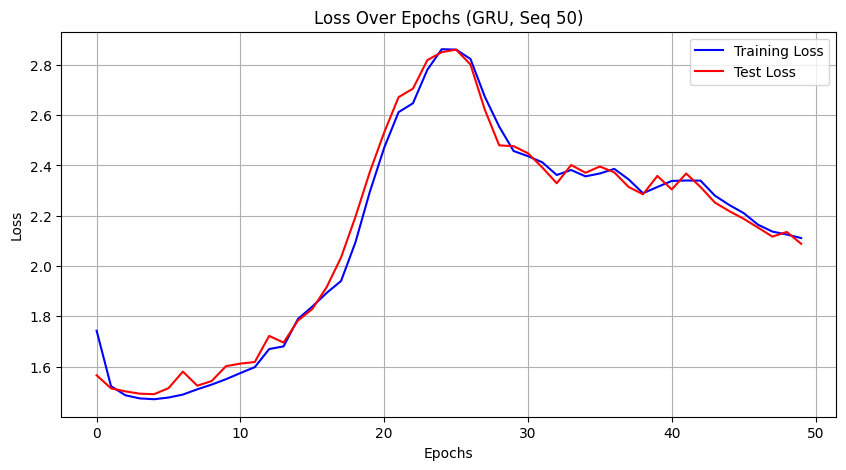


Generating text for GRU | Seq Length 50:
ROMEO:

PER ELUCK:
Wasttl you he.


CAMEN:
Wid yoo, lowe, bith sealllelauly,
Whele dare for vell, here suelould the let of of the shalle' the mever the will-s bet wame alle weay rety;
The and that ture thou

--------------------------------------------------------------------------------



In [ ]:
#PROBLEM 2

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
from google.colab import files
uploaded = files.upload()

#Shakespeare dataloader
from shakespeareloader import char_to_int, int_to_char, train_loader, test_loader


#RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, rnn_type='lstm'):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.lower()

        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'lstm' or 'gru'")

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        if hidden is None:
            if self.rnn_type == 'lstm':
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
                hidden = (h0, c0)
            else:
                hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

# Function to generate text
def generate_text(model, seed_text, predict_len=200, temperature=0.8):
    model.eval()
    device = next(model.parameters()).device
    context = [char_to_int[c] for c in seed_text]
    generated_text = seed_text

    with torch.no_grad():
        for _ in range(predict_len):
            x = torch.tensor(context[-20:]).unsqueeze(0).to(device)
            x_one_hot = torch.nn.functional.one_hot(x, num_classes=len(char_to_int)).float()
            output, _ = model(x_one_hot)
            output = output / temperature
            probs = torch.nn.functional.softmax(output, dim=-1)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = int_to_char[next_char_idx]
            generated_text += next_char
            context.append(next_char_idx)

    return generated_text

#train and evaluate
def train_and_evaluate(rnn_type, seq_length, hidden_size=128, num_layers=2, epochs=50, batch_size=64, lr=0.003):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RNNModel(len(char_to_int), hidden_size, num_layers, len(char_to_int), rnn_type).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses, accuracies = [], [], []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_x_one_hot = torch.nn.functional.one_hot(batch_x, num_classes=len(char_to_int)).float()

            optimizer.zero_grad()
            output, _ = model(batch_x_one_hot)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        #Evaluation
        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                batch_x_one_hot = torch.nn.functional.one_hot(batch_x, num_classes=len(char_to_int)).float()
                output, _ = model(batch_x_one_hot)
                loss = criterion(output, batch_y)
                test_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"{rnn_type.upper()} | Seq {seq_length} | Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")

    training_time = time.time() - start_time
    model_size = sum(p.numel() for p in model.parameters()) / 1e6  #MB

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Over Epochs ({rnn_type.upper()}, Seq {seq_length})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, test_losses, accuracies, training_time, model_size

results = {}
for model_type in ["lstm", "gru"]:
    for seq_length in [20, 30, 50]:
        model, train_losses, test_losses, accuracies, training_time, model_size = train_and_evaluate(model_type, seq_length)
        results[(model_type, seq_length)] = (model, train_losses, test_losses, accuracies, training_time, model_size)
        print(f"\nGenerating text for {model_type.upper()} | Seq Length {seq_length}:")
        print(generate_text(model, seed_text="ROMEO:", predict_len=200))
        print("\n" + "-"*80 + "\n")
